##### Goal: Find out which game company has a higher overall rating (Valve vs Blizzard)

## Web Scraping

In [1]:
from bs4 import BeautifulSoup as bs
import requests

In [2]:
valve_url = 'https://en.wikipedia.org/wiki/List_of_Valve_games'
blizzard_url = 'https://en.wikipedia.org/wiki/List_of_Blizzard_Entertainment_games'

valve_html = requests.get(valve_url)
blizzard_html = requests.get(blizzard_url)

In [3]:
soup = bs(valve_html.content)

contents = soup.prettify()

#print(contents)

In [4]:
games = soup.select('.wikitable i a')
game_path = games[0]['href']

#game_path

In [5]:
def get_game_links(url):
    html = requests.get(url)
    soup = bs(html.content)
    games = soup.select('.wikitable i a')
    games = soup.select('.wikitable .fn i a')
    game_links = []
    base_path = 'https://en.wikipedia.org'

    for game in games:
        # subdirectory example: "/wiki/Half-Life_(video_game)"
        game_subdirectory = game['href']
        path = base_path + game_subdirectory
        game_links.append(path)
    
    return game_links

#get_game_links('https://en.wikipedia.org/wiki/List_of_Valve_games')

Cleaning covers:
- Remove references [a] [1] etc
- Convert from all li elements in one string to list of strings
- Remove whitespace chars like br, \n, xa0, etc
- Convert from release date string to datetime objects
- Remove random strings in list at the end like (text), '', ':'

In [6]:
import re

def remove_ref(contents):
    # regular expression to find all matches with format [c] where c is any character eg. [a] or [1]
    reference = r'\[.\]'
    
    if type(contents) == str:
        matches = re.findall(reference, contents)
        # for each match, remove it from the string
        for match in matches:
            contents = contents.replace(match, '')
        # final remove whitespace that might've been between ref n text
        contents = contents.strip()
        return contents
    
    elif type(contents) == list:
        contents_list = []
        for my_string in contents:
            matches = re.findall(reference, my_string)
            for match in matches:
                my_string = my_string.replace(match, '')
                # final remove whitespace that might've been between ref n text
                my_string = my_string.strip()
            contents_list.append(my_string)
        return contents_list

In [7]:
def get_row_contents(row):
    # to handle releases
    # strip=True to remove whitespace chars (\n, xa0, etc)
    if row.select('li ul li'):
        return [li.get_text('', strip=True) for li in row.select('li ul li')]
    elif row.find('li'):
        return [li.get_text('', strip=True) for li in row.find_all('li')]
    elif row.find('br'):
        # stripped strings strips out whitespace chars
        return [text for text in row.find('td').stripped_strings]
    elif "," in row.get_text():
        return [text.strip() for text in row.find('td', class_='infobox-data').get_text().split(',')]
    else:  
        #print(row)
        return row.find('td', class_='infobox-data').get_text()

In [8]:
import re

def standardise_date(date):
    # other date format
    uncommon_date_re = r'\d+[ ][A-Za-z]+[ ]\d+'
    if re.search(uncommon_date_re, date):
        # first split string to list
        # eg. 15 June 2005 to [15, 'June', 2005]
        split_date = date.split()
        # make date string like this: June 15, 2005
        new_date = f'{split_date[1]} {split_date[0]}, {split_date[2]}'
        return new_date
    else:
        return date

standardise_date('15 June 2005')

'June 15, 2005'

In [9]:
from datetime import datetime

def convert_to_datetime(date_str):
    date_format = '%B %d, %Y'
    date = datetime.strptime(date_str, date_format)
    return date

convert_to_datetime('June 15, 2005')

datetime.datetime(2005, 6, 15, 0, 0)

In [10]:
import re

def get_release_date(row):
    if row.select('ul li'):
        contents = [li.get_text('', strip=True) for li in row.select('ul li')]
        #print('in ul li if statement')
    else:
        contents = row.find('td', class_='infobox-data').get_text()
        #print('in everything else')
    #print(contents)
    # June 15, 2005 or 15 June 2005 
    date_re = r'([A-Za-z]+[ ]\d+,[ ]\d+)|(\d+[ ][A-Za-z]+[ ]\d+)'
    
    if type(contents) == str:
        match = re.search(date_re, contents)
        date = match.group()
        standardised_date = standardise_date(date)
        datetime_obj = convert_to_datetime(standardised_date)
        return datetime_obj
    elif type(contents) == list:
        for i, item in enumerate(contents):
            match = re.search(date_re, item)
            #print(i, match)
            if (match != None):
                date = match.group()
                standardised_date = standardise_date(date)
                datetime_obj = convert_to_datetime(standardised_date)
                return datetime_obj
        return None

#get_release_date(['Microsoft Windows', '29 November 2006', 'Mac OS X', '23 September 2010', 'Linux', '5 June 2013'])

#### Scrape game ratings from Metacritic

In [11]:
import re

def name_to_link(name):
    # matches when a char is not a-zA-Z or 0-9 or "_"
    alphanumeric_re = r'\W'
    
    name = name.lower()
    name = name.replace(' ', '_')
    name = name.replace('-', '_')
    # remove matches of non alphanumeric or "_"
    name = re.sub(alphanumeric_re, '', name)
    name = name.replace('_', '-')
    
    return name

#print(name_to_link('Garry\'s Mod'))
#print(name_to_link('Half life 2: Lost Coast'))

In [12]:
def get_game_rating(name):
    # change name to link format
    # eg. https://www.metacritic.com/game/pc/garrys-mod, https://www.metacritic.com/game/pc/half-life
    name = name_to_link(name)
    url = f'https://www.metacritic.com/game/pc/{name}'

    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)
    soup = bs(response.content)
    
    metascore = soup.find('span', itemprop='ratingValue')
    if metascore is not None:
        metascore_str = metascore.get_text()
    else:
        metascore_str = 'N/A'
        
    userscore = soup.select('.score_summary .metascore_anchor .metascore_w.user')
    # by default returns empty list
    if len(userscore) > 0:
        userscore_str = userscore[0].get_text()
    else:
        userscore_str = 'N/A'
    
    return metascore_str, userscore_str

In [13]:
# deal with random (text) and '' whitespaces at the end
def remove_random_contents(contents):
    # to match format (Japan something) or ':'
    random_re = r'(\(*\))|[:]'
    if type(contents) == list:
        for item in contents:
            # if find item in format (Japan something) or ':' or empty string ''
            if re.search(random_re, item) or len(item) == 0:
                # remove that item from contents
                contents.remove(item)
    return contents

In [14]:
def get_info_box(url):
    game_html = requests.get(url)
    game_soup = bs(game_html.content)
    base_path = 'https://en.wikipedia.org'
    
    info_box = game_soup.find('table', class_='infobox')
    info_rows = info_box.find_all('tr')
    
    game_info = {}
    
    for i, row in enumerate(info_rows):
        # get title from infobox
        if row.select('.infobox-above'):
            game_info['Name'] = row.find('th').get_text()
            # handling really rare edge case with different naming
            if game_info['Name'] == 'Hearthstone':
                game_info['Name'] = 'Hearthstone: Heroes of Warcraft'
        # get image link from infobox
        elif row.select('.infobox-image'):
            image_link = base_path + row.find('a')['href']
            game_info['Image_link'] = image_link
        else:
            label = row.find('th', class_='infobox-label').get_text()
            contents = get_row_contents(row)
            contents = remove_ref(contents)
            if (label == 'Release'):
                #print(contents)
                contents = get_release_date(row)
                #print(contents)
            #print(contents)
            contents = remove_random_contents(contents)
            #print(contents)
            #print(f'Label: {label}, type: {type(contents)}')
                
            #print(contents)
            game_info[label] = contents
    
    # if no Release label found, it's not yet released
    if 'Release' not in game_info:
        game_info['Release'] = None
    
    game_info['Source'] = url
    
    metascore, userscore = get_game_rating(game_info['Name'])
    game_info['Metascore'] = metascore
    game_info['User Score'] = userscore
    
    return game_info
    
#get_info_box('https://en.wikipedia.org/wiki/Justice_League_Task_Force_(video_game)')

In [15]:
def scrape_game_company(url):
    game_links = get_game_links(url)
    games_info = []
    for i, link in enumerate(game_links):
        try:
            games_info.append(get_info_box(link))
            if (i % 10 == 0):
                print(f'--Scraped {i} games--')

        except Exception as e:
            print(link)
            print(e)

    print(f'Scraping finished with {i} games')
    return games_info

In [16]:
valve_games = scrape_game_company(valve_url)
#valve_games

--Scraped 0 games--
--Scraped 10 games--
--Scraped 20 games--
Scraping finished with 26 games


In [17]:
# ignore exceptions (they're games that haven't been released)
blizzard_games = scrape_game_company(blizzard_url)
#blizzard_games

--Scraped 0 games--
--Scraped 10 games--
--Scraped 20 games--
Scraping finished with 21 games


In [18]:
# see random game scraped
blizzard_games[10]

{'Name': 'StarCraft',
 'Image_link': 'https://en.wikipedia.org/wiki/File:StarCraft_box_art.jpg',
 'Developer(s)': 'Blizzard Entertainment',
 'Publisher(s)': 'Blizzard Entertainment',
 'Designer(s)': ['Chris Metzen', 'James Phinney'],
 'Composer(s)': ['Derek Duke',
  'Jason Hayes',
  'Glenn Stafford',
  'Tracy W. Bush'],
 'Series': 'StarCraft',
 'Platform(s)': ['Microsoft Windows', 'Classic Mac OS', 'Nintendo 64'],
 'Release': datetime.datetime(1998, 3, 31, 0, 0),
 'Genre(s)': 'Real-time strategy',
 'Mode(s)': ['Single-player', 'multiplayer'],
 'Source': 'https://en.wikipedia.org/wiki/StarCraft_(video_game)',
 'Metascore': '88',
 'User Score': '9.1'}

#### Save games to different file formats

In [19]:
from datetime import datetime

# converts datetime objects in game dictionaries to strings
def json_friendly(game_dict):
    for game in game_dict:
        datetime_obj = game['Release']
        if datetime_obj == None:
            continue
        date_str = datetime_obj.strftime('%B %d, %Y')
        game['Release'] = date_str
    return game_dict
    
#a = json_friendly(blizzard_games)

In [20]:
# Save and load JSON files - compatible with most programming languages
import json

def save_json(filename, data):
    data = json_friendly(data)
    with open(filename, 'w') as f:
        json.dump(data, f)
        
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [21]:
# Save and load pickle files - can store python specific objects like datetime
import pickle

def save_pickle(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [22]:
save_pickle('valve_cleaned_pickle.pickle', valve_games)
save_pickle('blizzard_cleaned_pickle.pickle', blizzard_games)

In [23]:
save_json('valve_cleaned_json.json', valve_games)
save_json('blizzard_cleaned_json.json', blizzard_games)

In [24]:
import pandas as pd

valve_df = pd.DataFrame.from_dict(valve_games)
blizzard_df = pd.DataFrame.from_dict(blizzard_games)

valve_df.to_csv('valve_cleaned_csv.csv', index=False)
blizzard_df.to_csv('blizzard_cleaned_csv.csv', index=False)

#### Try loading data in

In [25]:
valve_json = load_json('valve_cleaned_json.json')
blizzard_json = load_json('blizzard_cleaned_json.json')

In [26]:
valve_games = load_pickle('valve_cleaned_pickle.pickle')
blizzard_games = load_pickle('blizzard_cleaned_pickle.pickle')

## EDA

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
import pandas as pd

valve_df = pd.read_csv('valve_cleaned_csv.csv')
valve_df.head()

,Name,Image_link,Developer(s),Publisher(s),Writer(s),Composer(s),Series,Engine,Platform(s),Release,Genre(s),Mode(s),Source,Metascore,User Score,Designer(s),Artist(s),Director(s),Producer(s),Programmer(s)
0,Half-Life,https://en.wikipedia.org/wiki/File:Half-Life_C...,Valve,Sierra Studios,Marc Laidlaw,Kelly Bailey,Half-Life,GoldSrc,"['Windows', 'PlayStation 2', 'OS X', 'Linux']","November 19, 1998",First-person shooter,"['Single-player', 'multiplayer']",https://en.wikipedia.org/wiki/Half-Life_(video...,96.0,9.1,NaN,NaN,NaN,NaN,NaN
1,Team Fortress Classic,https://en.wikipedia.org/wiki/File:Team_Fortre...,Valve,['Sierra Studios'],NaN,NaN,NaN,GoldSrc,"['Microsoft Windows', 'OS X', 'Linux']","April 07, 1999",First-person shooter,Multiplayer,https://en.wikipedia.org/wiki/Team_Fortress_Cl...,NaN,7.2,"['John Cook', 'Robin Walker']",NaN,NaN,NaN,NaN
2,Counter-Strike,https://en.wikipedia.org/wiki/File:Counter-Str...,Valve,['Sierra Studios'],NaN,NaN,Counter-Strike,GoldSrc,"['Windows', 'Xbox', 'OS X', 'Linux']","November 09, 2000",First-person shooter,Multiplayer,https://en.wikipedia.org/wiki/Counter-Strike_(...,88.0,9.2,"['Minh Le', 'Jess Cliffe']",NaN,NaN,NaN,NaN
3,Day of Defeat,https://en.wikipedia.org/wiki/File:Day_of_Defe...,Valve,['Activision'],NaN,Michael Gordon Shapiro,NaN,GoldSrc,"['Microsoft Windows', 'OS X', 'Linux']","May 06, 2003",First-person shooter,Multiplayer,https://en.wikipedia.org/wiki/Day_of_Defeat,79.0,9.0,NaN,NaN,NaN,NaN,NaN
4,Counter-Strike: Condition Zero,https://en.wikipedia.org/wiki/File:CZbox.jpg,"['Ritual Entertainment', 'Turtle Rock Studios'...",['Sierra Entertainment'],NaN,NaN,Counter-Strike,GoldSrc,"['Windows', 'OS X', 'Linux']","March 23, 2004",First-person shooter,"['Single-player', 'multiplayer']",https://en.wikipedia.org/wiki/Counter-Strike:_...,65.0,8.7,NaN,NaN,NaN,NaN,NaN


In [70]:
#blizzard_df = pd.read_csv('blizzard_cleaned_csv.csv')
#blizzard_df.head()

In [71]:
# columns
valve_df.columns

Index(['Name', 'Image_link', 'Developer(s)', 'Publisher(s)', 'Writer(s)',
       'Composer(s)', 'Series', 'Engine', 'Platform(s)', 'Release', 'Genre(s)',
       'Mode(s)', 'Source', 'Metascore', 'User Score', 'Designer(s)',
       'Artist(s)', 'Director(s)', 'Producer(s)', 'Programmer(s)'],
      dtype='object')

In [72]:
valve_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           27 non-null     object 
 1   Image_link     27 non-null     object 
 2   Developer(s)   27 non-null     object 
 3   Publisher(s)   27 non-null     object 
 4   Writer(s)      11 non-null     object 
 5   Composer(s)    17 non-null     object 
 6   Series         20 non-null     object 
 7   Engine         27 non-null     object 
 8   Platform(s)    27 non-null     object 
 9   Release        27 non-null     object 
 10  Genre(s)       27 non-null     object 
 11  Mode(s)        27 non-null     object 
 12  Source         27 non-null     object 
 13  Metascore      20 non-null     float64
 14  User Score     27 non-null     float64
 15  Designer(s)    9 non-null      object 
 16  Artist(s)      2 non-null      object 
 17  Director(s)    2 non-null      object 
 18  Producer(s) 

In [73]:
valve_df = valve_df.drop(['Image_link', 'Source'], axis=1)
valve_df.head()

,Name,Developer(s),Publisher(s),Writer(s),Composer(s),Series,Engine,Platform(s),Release,Genre(s),Mode(s),Metascore,User Score,Designer(s),Artist(s),Director(s),Producer(s),Programmer(s)
0,Half-Life,Valve,Sierra Studios,Marc Laidlaw,Kelly Bailey,Half-Life,GoldSrc,"['Windows', 'PlayStation 2', 'OS X', 'Linux']","November 19, 1998",First-person shooter,"['Single-player', 'multiplayer']",96.0,9.1,NaN,NaN,NaN,NaN,NaN
1,Team Fortress Classic,Valve,['Sierra Studios'],NaN,NaN,NaN,GoldSrc,"['Microsoft Windows', 'OS X', 'Linux']","April 07, 1999",First-person shooter,Multiplayer,NaN,7.2,"['John Cook', 'Robin Walker']",NaN,NaN,NaN,NaN
2,Counter-Strike,Valve,['Sierra Studios'],NaN,NaN,Counter-Strike,GoldSrc,"['Windows', 'Xbox', 'OS X', 'Linux']","November 09, 2000",First-person shooter,Multiplayer,88.0,9.2,"['Minh Le', 'Jess Cliffe']",NaN,NaN,NaN,NaN
3,Day of Defeat,Valve,['Activision'],NaN,Michael Gordon Shapiro,NaN,GoldSrc,"['Microsoft Windows', 'OS X', 'Linux']","May 06, 2003",First-person shooter,Multiplayer,79.0,9.0,NaN,NaN,NaN,NaN,NaN
4,Counter-Strike: Condition Zero,"['Ritual Entertainment', 'Turtle Rock Studios'...",['Sierra Entertainment'],NaN,NaN,Counter-Strike,GoldSrc,"['Windows', 'OS X', 'Linux']","March 23, 2004",First-person shooter,"['Single-player', 'multiplayer']",65.0,8.7,NaN,NaN,NaN,NaN,NaN


In [74]:
# Valve games usually developed by company itself
valve_df['Developer(s)'].value_counts()

Valve                                                       22
['Valve', 'Hidden Path Entertainment']                       1
Facepunch Studios                                            1
['Valve', 'Turtle Rock Studios']                             1
Valve South                                                  1
['Ritual Entertainment', 'Turtle Rock Studios', 'Valve']     1
Name: Developer(s), dtype: int64

In [75]:
valve_df['Publisher(s)'].value_counts()

Valve                       20
['Valve']                    2
['Sierra Studios']           2
['Activision']               1
Sierra Studios               1
['Sierra Entertainment']     1
Name: Publisher(s), dtype: int64

In [76]:
valve_df['Writer(s)'].value_counts()

['Erik Wolpaw', 'Chet Faliszek']                                   3
Marc Laidlaw                                                       2
Chet Faliszek                                                      2
['Erik Wolpaw', 'Jay Pinkerton', 'Chet Faliszek']                  1
['Jay Pinkerton', 'Sean Vanaman', 'Erik Wolpaw', 'Jake Rodkin']    1
Steve Jaros                                                        1
['Marc Laidlaw', 'Ted Kosmatka', 'Kris Katz']                      1
Name: Writer(s), dtype: int64

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

score_data = valve_df[['Name', 'Metascore', 'User Score']]
# create boolean missing in case we need it for color coding later
score_data['Missing Metascore'] = [np.isnan(x) for x in score_data['Metascore']]
score_data

,Name,Metascore,User Score,Missing Metascore
0,Half-Life,96.0,9.1,False
1,Team Fortress Classic,NaN,7.2,True
2,Counter-Strike,88.0,9.2,False
3,Day of Defeat,79.0,9.0,False
4,Counter-Strike: Condition Zero,65.0,8.7,False
5,Counter-Strike: Source,88.0,8.9,False
6,Half-Life 2,96.0,9.2,False
7,Half-Life 2: Deathmatch,NaN,7.3,True
8,Day of Defeat: Source,80.0,9.0,False
9,Half-Life 2: Lost Coast,NaN,7.9,True


In [78]:
np.isnan(score_data['Metascore'][1])

True

In [79]:
score_data['Metascore filled'] = [uscore * 10 if np.isnan(score_data['Metascore'][i]) 
                    else score_data['Metascore'][i] for i, uscore in enumerate(score_data['User Score'])]
score_data

,Name,Metascore,User Score,Missing Metascore,Metascore filled
0,Half-Life,96.0,9.1,False,96.0
1,Team Fortress Classic,NaN,7.2,True,72.0
2,Counter-Strike,88.0,9.2,False,88.0
3,Day of Defeat,79.0,9.0,False,79.0
4,Counter-Strike: Condition Zero,65.0,8.7,False,65.0
5,Counter-Strike: Source,88.0,8.9,False,88.0
6,Half-Life 2,96.0,9.2,False,96.0
7,Half-Life 2: Deathmatch,NaN,7.3,True,73.0
8,Day of Defeat: Source,80.0,9.0,False,80.0
9,Half-Life 2: Lost Coast,NaN,7.9,True,79.0


In [80]:
data_for_cluster = score_data[['Metascore filled', 'User Score']]

kmeans = KMeans(n_clusters=4, random_state=0).fit(data_for_cluster)
clusters = kmeans.predict(data_for_cluster)
score_data['Cluster'] = clusters
score_data

,Name,Metascore,User Score,Missing Metascore,Metascore filled,Cluster
0,Half-Life,96.0,9.1,False,96.0,3
1,Team Fortress Classic,NaN,7.2,True,72.0,2
2,Counter-Strike,88.0,9.2,False,88.0,0
3,Day of Defeat,79.0,9.0,False,79.0,1
4,Counter-Strike: Condition Zero,65.0,8.7,False,65.0,2
5,Counter-Strike: Source,88.0,8.9,False,88.0,0
6,Half-Life 2,96.0,9.2,False,96.0,3
7,Half-Life 2: Deathmatch,NaN,7.3,True,73.0,2
8,Day of Defeat: Source,80.0,9.0,False,80.0,1
9,Half-Life 2: Lost Coast,NaN,7.9,True,79.0,1


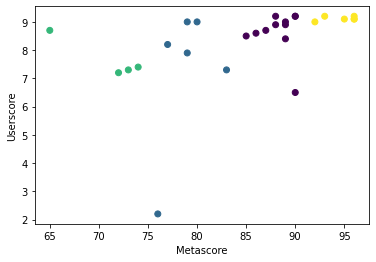

In [82]:
plt.scatter(score_data['Metascore filled'], score_data['User Score'], c=score_data['Cluster'])
plt.xlabel('Metascore')
plt.ylabel('Userscore')
plt.show()

<AxesSubplot:>

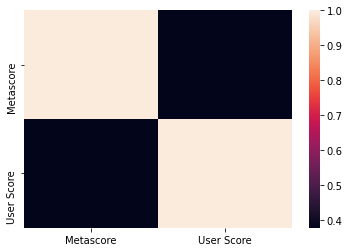

In [9]:
sns.heatmap(valve_df[['Metascore', 'User Score']].corr())

In [ ]:
# questions to answer:
    # which gaming company has a better overall rating
        # cluster metascores (maybe color code by user score)
    # do scores improve over time (release date)
    # do games without recorded writers/composers etc have better score
    # relation between genre and score

Tasks:
- Scrape both websites
- Convert to dictionary
- Convert to pandas
- Do some EDA
- Make insights